In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

%matplotlib inline

from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import  lightgbm as lgb
from catboost import CatBoostClassifier,Pool
from catboost.utils import eval_metric

from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_submission=pd.read_csv('sample_submission.csv')
df_test=pd.read_csv('test.csv')
df_train=pd.read_csv('train.csv')

In [14]:
df_test_ov=df_test.copy()
df_test.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148
5,11504803,Male,22,1,30.0,1,< 1 Year,No,25715.0,152.0,245
6,11504804,Female,23,1,20.0,0,< 1 Year,Yes,2630.0,152.0,11
7,11504805,Female,21,1,37.0,1,< 1 Year,Yes,2630.0,160.0,171
8,11504806,Male,72,1,43.0,1,1-2 Year,No,38495.0,124.0,97
9,11504807,Male,33,1,28.0,1,< 1 Year,No,46937.0,152.0,72


In [5]:
pd.set_option('display.max_columns',None)

In [6]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [7]:
num_train_rows,num_train_columns=df_train.shape
num_test_rows,num_test_columns=df_test.shape
num_submission_rows,num_submission_columns=df_submission.shape

print("Training Data:")
print(f"Number of Rows: {num_train_rows}")
print(f"Number of Columns: {num_train_columns}\n")

print("Test Data:")
print(f"Number of Rows: {num_test_rows}")
print(f"Number of Columns: {num_test_columns}\n")

print("Submission Data:")
print(f"Number of Rows: {num_submission_rows}")
print(f"Number of Columns: {num_submission_columns}")

Training Data:
Number of Rows: 11504798
Number of Columns: 12

Test Data:
Number of Rows: 7669866
Number of Columns: 11

Submission Data:
Number of Rows: 7669866
Number of Columns: 2


In [8]:
train_null=df_train.isnull().sum().sum()
test_null=df_test.isnull().sum().sum()
submission_null=df_submission.isnull().sum().sum()
print(f'Null Count in Train: {train_null}')
print(f'Null Count in Test: {test_null}')
print(f'Null Count in Submission: {submission_null}')

Null Count in Train: 0
Null Count in Test: 0
Null Count in Submission: 0


In [9]:
train_duplicates=df_train.duplicated().sum()
test_duplicates=df_test.duplicated().sum()
submission_duplicates=df_submission.duplicated().sum()
print(f"Number of duplicate rows in train_data: {train_duplicates}")
print(f"Number of duplicate rows in test_data: {test_duplicates}")
print(f"Number of duplicate rows in test_data: {submission_duplicates}")

Number of duplicate rows in train_data: 0
Number of duplicate rows in test_data: 0
Number of duplicate rows in test_data: 0


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


In [11]:
df_train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
mean,5.752398e+06,3.838356e+01,9.980220e-01,2.641869e+01,4.629966e-01,3.046137e+04,1.124254e+02,1.638977e+02,1.229973e-01
std,3.321149e+06,1.499346e+01,4.443120e-02,1.299159e+01,4.986289e-01,1.645475e+04,5.403571e+01,7.997953e+01,3.284341e-01
min,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,2.876199e+06,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,2.527700e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,5.752398e+06,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,8.628598e+06,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,3.945100e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,1.150480e+07,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


In [12]:
sns.set_style("white")
sns.set(rc={"axes.facecolor":"#E8CE9D","figure.facecolor":"#E8CE9D","grid.color":"white"})
sns.set_context("poster",font_scale = .7)

# palette = ["#432C0A","#f7941d","#6c9a76","#f25a29","#cc4b57"]
palette = ["#764a23","#f7941d","#6c9a76","#f25a29","#cc4b57"]
palette_cmap = ["#6c9a76","#cc4b57","#764a23","#f25a29","#f7941d"]

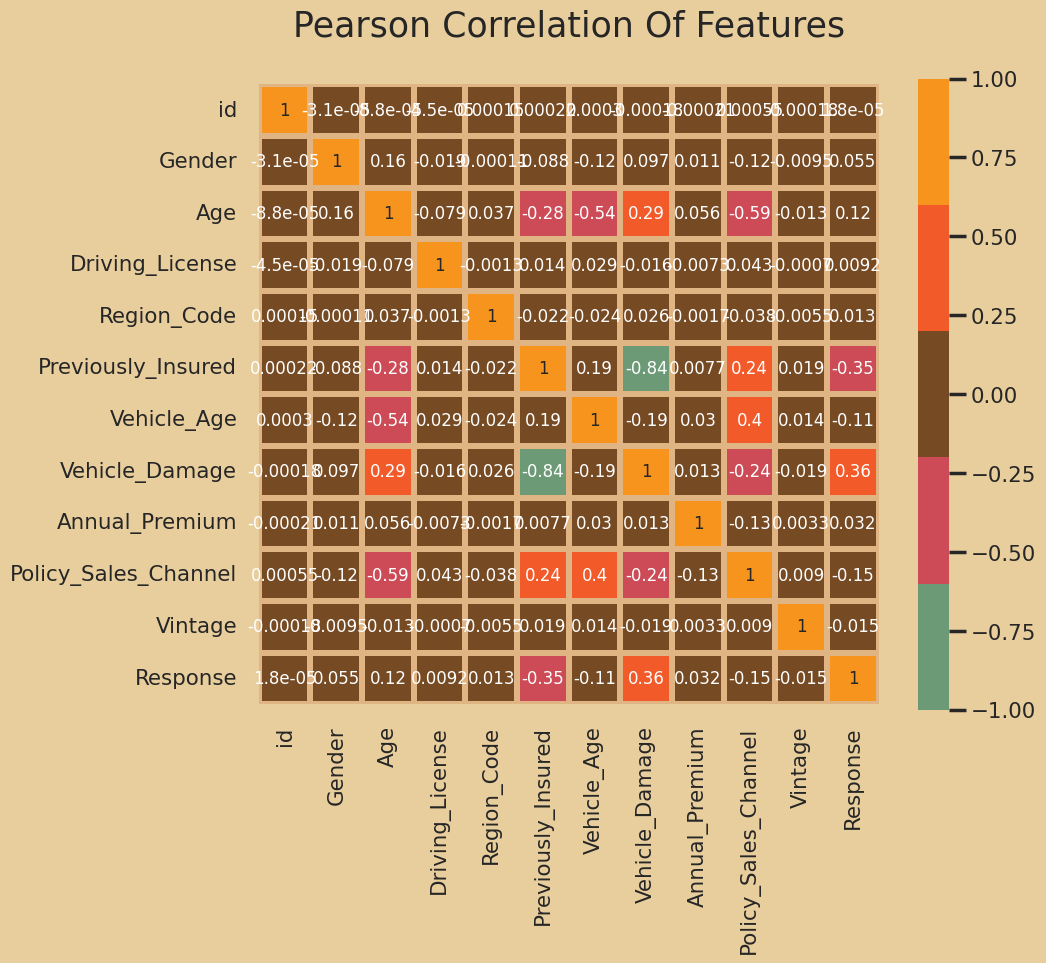

In [13]:
df_corr = df_train.copy()

catcol = [col for col in df_corr.columns if df_corr[col].dtype == "object"]
le = LabelEncoder()
for col in catcol:
        df_corr[col] = le.fit_transform(df_corr[col])


plt.subplots(figsize =(10, 10))

sns.heatmap(df_corr.corr(), cmap = palette_cmap, square=True, cbar_kws=dict(shrink =.82), 
            annot=True, vmin=-1, vmax=1, linewidths=3,linecolor='#e0b583',annot_kws=dict(fontsize =12))
plt.title("Pearson Correlation Of Features\n", fontsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()